#Convolutional Forest (ConvRF) Kappas Experiment for 3-Class Multiclassification

The goal of this experiment is to demonstrate the capabilities of a convolutional forest against benchmarks such as naive random forests, simple CNN's, CNN with 32 filter and 1 layer, and CNN with 32 filter and 2 layers. 12 3-class Cifar10 classification tasks were, and plot of the pairwise Cohen's Kappa Statistic differences between ConvRF vs naive RF, ConvRF vs simple CNN, ConvRF vs CNN 32 filter and 1 layer, and ConvRF vs CNN 32 filter and 2 layers were constucted. Plots include the individual Kappa Statistic for each class combination and box plot for all class combinations.

Note: 
1.   This experiment uses the class file and functions from `./functions/ConvRF.py`
2.   This is expeeriment is based on work of `ypeng22/ConvRFClassifier` and `tpsatish95/deep-conv-rf`



In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import functions.ConvRF as ConvRF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

sns.set()
import warnings

warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

##Set parameters

Figure parameters for plotting were set and warnings were disabled

In [3]:
%matplotlib inline
plt.rcParams["legend.loc"] = "best"
plt.rcParams["figure.facecolor"] = "white"
names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# filter python warnings
def run():
    torch.multiprocessing.freeze_support()


if __name__ == "__main__":
    run()

##Obtain CIFAR
CIFAR10 dataset was downloaded and normalized.

In [4]:
# prepare CIFAR data

# normalize
scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root="./", train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.data)
cifar_train_labels = np.array(cifar_trainset.targets)

# test data
cifar_testset = datasets.CIFAR10(root="./", train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.data)
cifar_test_labels = np.array(cifar_testset.targets)

# transform
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = datasets.CIFAR10(root="./", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="./", train=False, download=True, transform=transform)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##Define CNN
CNN architectures for simple CNN's, CNN with 32 filter and 1 layer, and CNN with 32 filter and 2 layers were defined.

In [5]:
# define 3 CNN arhcitectures
class SimpleCNNOneFilter(nn.Module):
    def __init__(self):
        super(SimpleCNNOneFilter, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144)
        x = self.fc1(x)
        return x


class SimpleCNN32Filter(nn.Module):
    def __init__(self):
        super(SimpleCNN32Filter, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144 * 32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144 * 32)
        x = self.fc1(x)
        return x


class SimpleCNN32Filter2Layers(nn.Module):
    def __init__(self):
        super(SimpleCNN32Filter2Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, stride=1)
        self.fc1 = nn.Linear(36 * 32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 36 * 32)
        x = self.fc1(x)
        return x

##Perform Experiment
Experiments for 12 combinations were performed for each algorithm

In [ ]:
# go through 12 combinations of experiments
res = {}
class1 = 0
for class2 in range(1, 4):
    for class3 in range(6, 10):

        # accuracy vs num training samples (naive_rf)
        naive_rf_acc_vs_n = list()
        fraction_of_train_samples_space = np.geomspace(0.01, 1, num=8)
        for fraction_of_train_samples in fraction_of_train_samples_space:
            RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf_3_class(
                        RF,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                    )
                    for _ in range(2)
                ]
            )
            naive_rf_acc_vs_n.append(best_accuracy)

        # accuracy vs num training samples (naive_rf)
        conv_rf_2_layer = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_2l = ConvRF.ConvRFClassifier(
                layers=2, kernel_size=(10, 5), stride=(2, 1)
            )
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf_3_class(
                        conv_rf_2l,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                    )
                    for _ in range(2)
                ]
            )
            conv_rf_2_layer.append(best_accuracy)

        # accuracy vs num training samples (naive_rf)
        conv_rf_apply = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_a = ConvRF.ConvRFClassifier(
                layers=1, kernel_size=(10,), stride=(2,)
            )
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf_3_class(
                        conv_rf_a,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                    )
                    for _ in range(2)
                ]
            )
            conv_rf_apply.append(best_accuracy)

        # accuracy vs num training samples (one layer cnn (32 filters))
        cnn32_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn_3_class(
                        SimpleCNN32Filter,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                        trainset,
                        testset,
                    )
                    for _ in range(2)
                ]
            )
            cnn32_acc_vs_n.append(best_accuracy)

        # accuracy vs num training samples (two layer cnn (32 filters))
        cnn32_two_layer_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn_3_class(
                        SimpleCNN32Filter2Layers,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                        trainset,
                        testset,
                    )
                    for _ in range(2)
                ]
            )
            cnn32_two_layer_acc_vs_n.append(best_accuracy)

            # accuracy vs num training samples (one layer cnn)
        cnn_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn_3_class(
                        SimpleCNNOneFilter,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        class3,
                        trainset,
                        testset,
                    )
                    for _ in range(2)
                ]
            )
            cnn_acc_vs_n.append(best_accuracy)

        table = pd.DataFrame(
            np.concatenate(
                (
                    [naive_rf_acc_vs_n],
                    [conv_rf_apply],
                    [conv_rf_2_layer],
                    [cnn_acc_vs_n],
                    [cnn32_acc_vs_n],
                    [cnn32_two_layer_acc_vs_n],
                ),
                axis=0,
            )
        )
        algos = [
            "naiveRF",
            "convrf",
            "convrf2layer",
            "simplecnn",
            "cnn32",
            "cnn32_2layer",
        ]
        table["algos"] = algos
        cols = table.columns.tolist()
        cols = [cols[-1]] + cols[:-1]
        cols = pd.Index(cols)
        table = table[cols]
        res[str(class1) + "_vs_" + str(class2) + "_vs_" + str(class3)] = table
        torch.cuda.empty_cache()

##Define kappa plots
Individual scatter plot and combinde box plots used for pairwise Kappa differences plots were defined.

In [15]:
def plot_kappa(algo1, algo2):
    # convrf vs naiverf
    kappas_subtract = []
    xs = []
    class1 = 0
    for class2 in range(1, 4):
        for class3 in range(6, 10):
            results = res[str(class1) + "_vs_" + str(class2) + "_vs_" + str(class3)]
            rf_err = 0.5 / (1 - results.iloc[algo2][1:])
            convrf_err = 0.5 / (1 - results.iloc[algo1][1:])
            kappa = convrf_err - rf_err
            kappas_subtract.extend(kappa)
            xs.extend([1, 2, 3, 4, 5, 6, 7, 8])

    ind1 = range(0, len(xs), 8)
    ind2 = range(1, len(xs), 8)
    ind3 = range(2, len(xs), 8)
    ind4 = range(3, len(xs), 8)
    ind5 = range(4, len(xs), 8)
    ind6 = range(5, len(xs), 8)
    ind7 = range(6, len(xs), 8)
    ind8 = range(7, len(xs), 8)

    plt.clf()
    for i in range(12):
        plt.plot(xs[i * 8 : i * 8 + 8], kappas_subtract[i * 8 : i * 8 + 8])
    plt.xticks(
        [1, 2, 3, 4, 5, 6, 7, 8],
        ["100", "194", "372", "720", "1390", "2682", "5180", "10000"],
    )
    plt.ylim(-1.25, 1.25)
    plt.xlabel("Number of Train Samples")
    plt.ylabel("Kappa")
    plt.title(algos[algo1] + " - " + algos[algo2] + " kappa vs # of Train Samples")
    plt.figure()

    plt.clf()
    box1 = [(kappas_subtract[i]) for i in ind1]
    box2 = [(kappas_subtract[i]) for i in ind2]
    box3 = [(kappas_subtract[i]) for i in ind3]
    box4 = [(kappas_subtract[i]) for i in ind4]
    box5 = [(kappas_subtract[i]) for i in ind5]
    box6 = [(kappas_subtract[i]) for i in ind6]
    box7 = [(kappas_subtract[i]) for i in ind7]
    box8 = [(kappas_subtract[i]) for i in ind8]
    boxs = [box1, box2, box3, box4, box5, box5, box7, box8]

    plt.boxplot(boxs)
    plt.xlabel("Number of Train Samples")
    plt.ylabel("Kappa")
    plt.title(algos[algo1] + " - " + algos[algo2] + " kappa vs # of Train Samples")
    plt.xticks(
        [1, 2, 3, 4, 5, 6, 7, 8],
        ["100", "194", "372", "720", "1390", "2682", "5180", "10000"],
    )
    plt.ylim(-1.25, 1.25)

##Plot kappa between ConvRF and NaiveRF
Plot of the pairwise Cohen's Kappa Statistic differences between ConvRF vs naive RF, ConvRF vs simple CNN, ConvRF vs CNN 32 filter and 1 layer, and ConvRF vs CNN 32 filter and 2 layers were constucted.

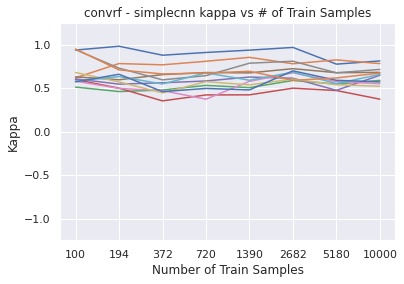

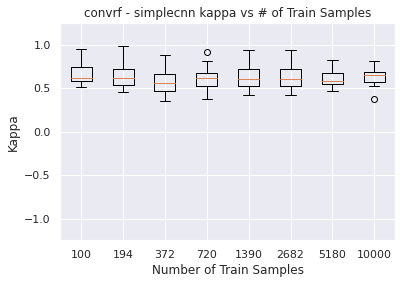

In [16]:
# ConvRF vs simple cnn
plot_kappa(1, 3)

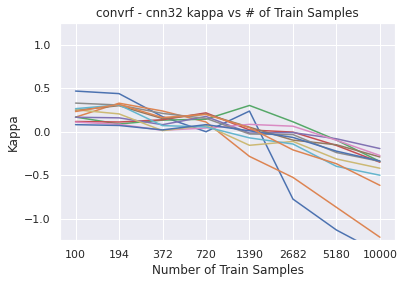

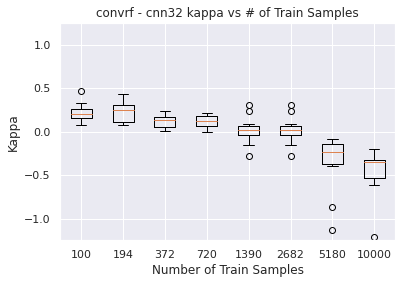

In [19]:
# ConvRF vs CNN 32 filter and 1 layer
plot_kappa(1, 4)

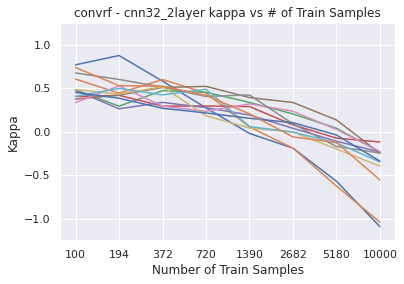

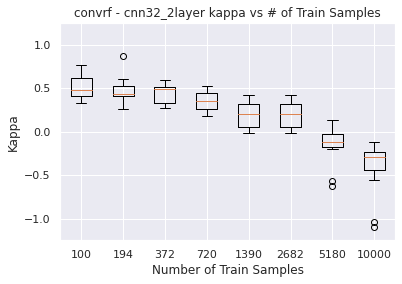

In [17]:
# ConvRF vs CNN 32 filter and 2 layers
plot_kappa(1, 5)

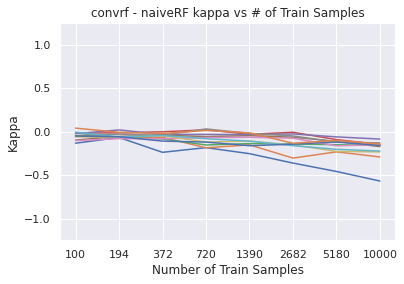

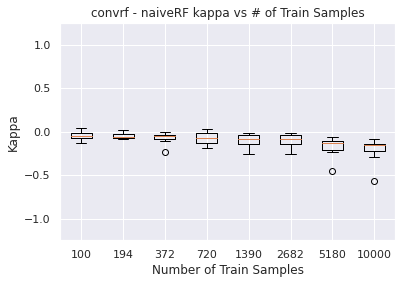

In [18]:
# convrf vs naiverf
plot_kappa(1, 0)